In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot

import matplotlib
matplotlib.rc('xtick',labelsize = 20)
matplotlib.rc('ytick',labelsize = 20)
########################
def geometricBar(weights, alldistribT):
    """return the weighted geometric mean of distributions"""
    assert (len(weights) == alldistribT.shape[1])
    return np.exp(np.dot(np.log(alldistribT), weights.T))


def geometricMean(alldistribT):
    """return the  geometric mean of distributions"""
    return np.exp(np.mean(np.log(alldistribT), axis=1))

### Sinkhorn type algo for OT Barycenter
def barycenter_sinkhorn(marginals, cost, epsilon, weights = None, maxiter=1000, stopThr=1e-4):

    K = np.exp(-cost/epsilon)
    cpt = 0
    err = 1
    vT = np.divide(marginals.T, np.sum(K, axis=0))
    UKv = np.dot(K, vT.T)
    u = (geometricMean(UKv) / UKv.T).T

    ###
    # u = np.ones((100,2))
    ###
    while (cpt < maxiter):# err > stopThr and
        cpt = cpt + 1
        Ku = np.dot(K, u)
        v = np.divide(marginals, Ku)
        Kv = np.dot(K,v)
        UKv = u*Kv
        # UKv = u * np.dot(K, np.divide(marginals, np.dot(K, u)))
        u = (u.T * geometricBar(weights, UKv)).T / UKv

    return geometricBar(weights, UKv)

In [3]:
n = 100
p = 2
x = np.linspace(1/n, 1, num=n)
cost = np.absolute(x - np.expand_dims(x, axis=1))
cost = np.power(cost, p)

# x = np.arange(n, dtype=np.float64)
# cost = ot.utils.dist0(n)
# cost /= cost.max()

p1 = ot.datasets.get_1D_gauss(n,20,8)#0.55 * ot.datasets.get_1D_gauss(n,20,8) + 0.45 * ot.datasets.get_1D_gauss(n,70,9)
p2 = 0.55 * ot.datasets.get_1D_gauss(n,35,9) + 0.45 * ot.datasets.get_1D_gauss(n,55,5)

# p1 = ot.datasets.get_1D_gauss(n, 35, 10)  # + 0.45 * ot.datasets.get_1D_gauss(n,80,9)
# p2 = ot.datasets.get_1D_gauss(n, 5, 10)
# creating matrix A containing all distributions
marginals = np.vstack((p1, p2)).T
n_distributions = marginals.shape[1]

num_timepoints = 20
def calculate_n_barycenter_sinkhorn(marginals, cost, epsilon, maxiter, num_timepoints):
    ret = []
    for time_idx in range(num_timepoints):  # 0<=alpha<=1
        alpha = time_idx/num_timepoints
        weights = np.array([1-alpha, alpha])

        barycenter1 = barycenter_sinkhorn(marginals, cost, epsilon=epsilon, weights=weights, maxiter=maxiter)
        ret.append(barycenter1.reshape(1, -1))
    return np.concatenate(ret, axis=0)
        # plt.figure(time_idx)
        # plt.clf()
        # plt.subplot(2, 1, 1)
        # for i in range(n_distributions):
        #     plt.plot(x, marginals[:, i])
        # plt.title('Two Marginal Distributions')

        # plt.subplot(2, 1, 2)
        # plt.plot(x, barycenter1, 'r', label='Sinkhorn')
        # plt.title(' time = '+str(alpha))
        # plt.tight_layout()
        # plt.show()
barycenter_ret = calculate_n_barycenter_sinkhorn(marginals, cost, 0.001, maxiter=1000, num_timepoints=20)

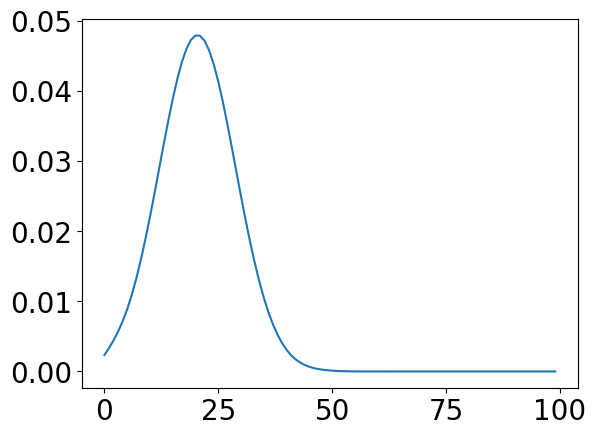

In [4]:
plt.plot(barycenter_ret[0])

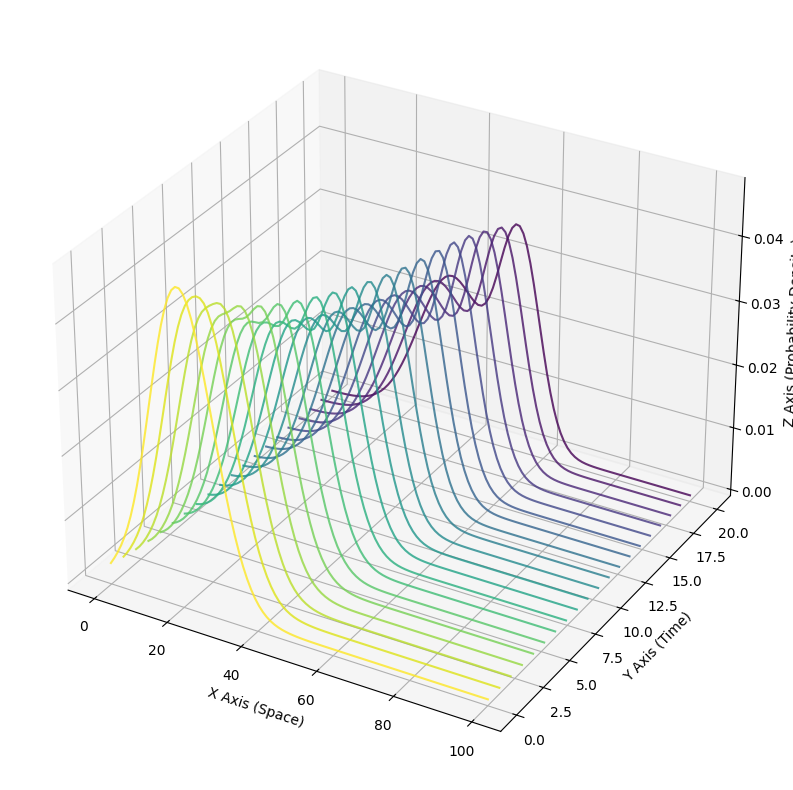

In [35]:
def plot_precomputed_pdf(pdf_values, x_range=None, time_range=None):
    """
    绘制预先计算好的随时间变化的一维概率密度函数。

    :param pdf_values: 形状为 (n_times, num_points) 的数组，包含概率密度值。
    :param x_range: 元组，表示一维空间变量的范围 (min, max)。
    :param time_range: 元组，表示时间的范围 (start, end)。
    """
    # 验证输入数组的形状
    n_times, num_points = pdf_values.shape

    # 创建空间变量和时间点
    times = np.linspace(0, n_times, n_times) if time_range is None else np.linspace(time_range[0], time_range[1], n_times)
    x =  np.linspace(0, num_points, num_points) if x_range is None else np.linspace(x_range[0], x_range[1], num_points)

    # 创建三维图形
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    # 用不同的颜色表示不同的时间
    colors = plt.cm.viridis(np.linspace(0, 1, n_times))

    # 绘制每个时间点的概率密度函数
    for t, y, c in zip(times[::-1], pdf_values[::-1], colors):
        ax.plot(x, y, zs=t, zdir='y', color=c, alpha=0.8)

    # 设置坐标轴标签
    ax.set_xlabel('X Axis (Space)')
    ax.set_ylabel('Y Axis (Time)')
    ax.set_zlabel('Z Axis (Probability Density)')

    # 设置刻度字体大小
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='z', labelsize=10)
    
    # 显示图形
    plt.show()
    
plot_precomputed_pdf(barycenter_ret)

In [12]:
import plotly.graph_objects as go
import numpy as np

def plot_precomputed_pdf_interactive(pdf_values, x_range=None, time_range=None):
    """
    使用 Plotly 绘制预先计算好的随时间变化的一维概率密度函数。

    :param pdf_values: 形状为 (n_times, num_points) 的数组，包含概率密度值。
    :param x_range: 元组，表示一维空间变量的范围 (min, max)。
    :param time_range: 元组，表示时间的范围 (start, end)。
    """
    # 验证输入数组的形状
    n_times, num_points = pdf_values.shape

    # 创建空间变量和时间点
    times = np.linspace(0, n_times, n_times) if time_range is None else np.linspace(time_range[0], time_range[1], n_times)
    x =  np.linspace(0, num_points, num_points) if x_range is None else np.linspace(x_range[0], x_range[1], num_points)

    # 创建 Plotly 图形
    fig = go.Figure()

    colors = [f'rgb({255-i}, {0+i}, 255)' for i in np.linspace(0, 255, n_times)]

    # 添加每个时间点的概率密度函数
    for t, y, c in zip(times, pdf_values.T, colors):
        fig.add_trace(go.Scatter3d(x=x, y=[t]*num_points, z=y, mode='lines', line=dict(color=c)))


    # 设置图形的布局
    fig.update_layout(
        scene=dict(
            xaxis_title='X Axis (Space)',
            yaxis_title='Y Axis (Time)',
            zaxis_title='Z Axis (Probability Density)'
        ),
        title='SBP_by_OTbarycentre'
    )

    # 显示图形
    fig.show()

plot_precomputed_pdf_interactive(barycenter_ret)
